In [238]:
%load_ext autoreload
%autoreload 2

import torch

import diveslowlearnfast as dlf
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from diveslowlearnfast.datasets import Diving48Dataset
from diveslowlearnfast.egl.explainer import ExplainerStrategy
from diveslowlearnfast.train.helper import get_test_transform
from diveslowlearnfast.models import SlowFast, load_checkpoint
from diveslowlearnfast.config import Config
from diveslowlearnfast.visualise.gradcam import GradCAM
from diveslowlearnfast.train import helper as train_helper, StatsDB
from diveslowlearnfast.egl import helper as egl_helper
from diveslowlearnfast.egl.generate_masks import generate_masks_from_localisation_maps

cfg = Config()
cfg.DATA.DATASET_PATH = '/Users/youritomassen/Projects/xai/data/Diving48/'
cfg.TRAIN.BATCH_SIZE = 2
# cfg.GRADCAM.TARGET_LAYERS = ['head/pathway0_avgpool', 'head/pathway1_avgpool']
cfg.GRADCAM.TARGET_LAYERS = ['s5/pathway0_res2', 's5/pathway1_res2']
device = torch.device('cpu')
model = SlowFast(cfg)
model = model.eval()
_, optimiser, *_ = train_helper.get_train_objects(cfg, model)
model, *_ = load_checkpoint(model, '../misc/checkpoint.pth', optimiser, device)
explainer = ExplainerStrategy.get_explainer(model, cfg=cfg, device=device)

stats_db = StatsDB('./data/stats.db')
difficult_samples = stats_db.get_below_median_samples(
    epoch_start=90,
    run_id='/home/s2871513/Projects/diveslowlearnfast/results/run18',
    split='train'
)

video_ids = list(map(lambda x: x[0], difficult_samples))

train_dataset = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    transform_fn=get_test_transform(cfg),
    dataset_type='train', # use test_transform instead
    use_decord=cfg.DATA_LOADER.USE_DECORD,
    temporal_random_jitter=cfg.DATA.TEMPORAL_RANDOM_JITTER,
    temporal_random_offset=cfg.DATA.TEMPORAL_RANDOM_OFFSET,
    multi_thread_decode=cfg.DATA.MULTI_THREAD_DECODE,
    threshold=cfg.DATA.THRESHOLD,
    use_dynamic_temporal_stride=cfg.DATA.USE_DYNAMIC_TEMPORAL_STRIDE,
    video_ids=video_ids
)

loader = DataLoader(
    train_dataset,
    batch_size=2,
    pin_memory=cfg.DATA_LOADER.PIN_MEMORY,
    num_workers=cfg.DATA_LOADER.NUM_WORKERS,
    shuffle=True,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



In [239]:
x, y, *_ = train_dataset[2]
x.shape, y, train_dataset.get_label(y)

(torch.Size([3, 32, 256, 256]), 5, ['Back', '25som', '15Twis', 'PIKE'])

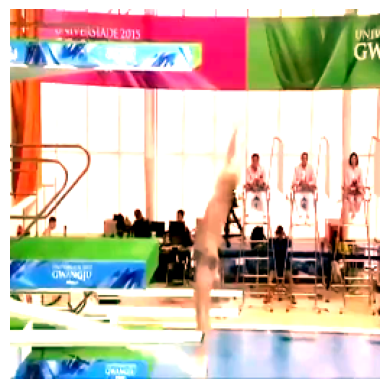

In [240]:
dlf.frameshow(x, frame_idx=0)

In [241]:
x_tensor = x.unsqueeze(0)
inputs = dlf.to_slowfast_inputs(x_tensor, cfg.SLOWFAST.ALPHA)
y_tensor = torch.tensor([y]).unsqueeze(0)

inputs[0].shape, inputs[1].shape, inputs[0].dtype, inputs[1].dtype

(torch.Size([1, 3, 4, 256, 256]),
 torch.Size([1, 3, 32, 256, 256]),
 torch.float32,
 torch.float32)

In [242]:
localisation_maps, logits = explainer(inputs, y=torch.tensor([5]))
y_pred = torch.softmax(logits, dim=1).argmax()
localisation_maps[0].shape, localisation_maps[1].shape, y_pred, y_pred == y

(torch.Size([1, 1, 4, 256, 256]),
 torch.Size([1, 1, 32, 256, 256]),
 tensor(5),
 tensor(True))

In [243]:
heatmaps = dlf.create_heatmaps(inputs, localisation_maps, cfg.DATA.MEAN, cfg.DATA.STD, colormap='jet')
heatmaps[0].shape, heatmaps[1].shape, heatmaps[0].dtype, heatmaps[1].dtype

(torch.Size([1, 3, 4, 256, 256]),
 torch.Size([1, 3, 32, 256, 256]),
 torch.float64,
 torch.float64)

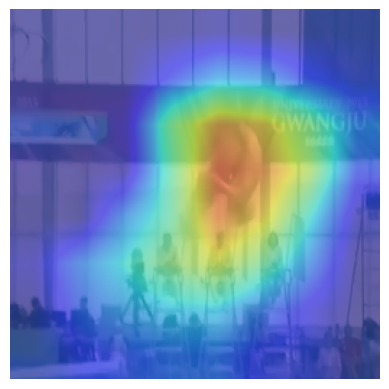

In [247]:
dlf.frameshow(heatmaps[0][0], frame_idx=2)

In [248]:

masks_slow_and_fast = generate_masks_from_localisation_maps(localisation_maps, cfg, indices=None)

TypeError: all() received an invalid combination of arguments - got (bool), but expected one of:
 * (Tensor input, *, Tensor out = None)
 * (Tensor input, tuple of ints dim = None, bool keepdim = False, *, Tensor out = None)
 * (Tensor input, int dim, bool keepdim = False, *, Tensor out = None)
 * (Tensor input, name dim, bool keepdim = False, *, Tensor out = None)


In [249]:
masks_slow_and_fast[0].shape, masks_slow_and_fast[1].shape

((2, 1, 4, 256, 256), (2, 1, 32, 256, 256))

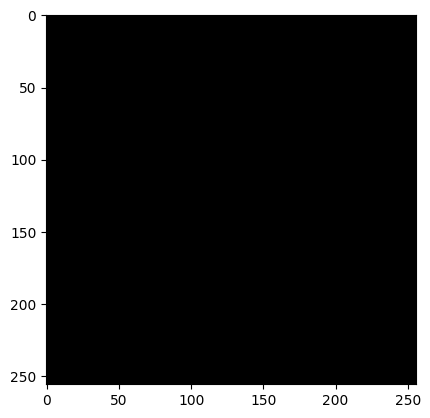

In [250]:
plt.imshow(masks_slow_and_fast[0][0][0][3], cmap='gray')

In [276]:
xb, yb, *_ = next(iter(loader))

In [277]:
inputs = dlf.to_slowfast_inputs(xb, cfg.SLOWFAST.ALPHA)
localisation_maps, logits = explainer(inputs, y=yb)
y_pred = torch.softmax(logits, dim=1).argmax(dim=1)
indices = y_pred != yb
y_pred, indices, yb

(tensor([31,  8]), tensor([ True, False]), tensor([34,  8]))

In [285]:
cfg.EGL.MASK_PERCENTILE = 95

masks_slow_and_fast = generate_masks_from_localisation_maps(localisation_maps, cfg, indices)
masks_slow = masks_slow_and_fast[0]
masks_fast = masks_slow_and_fast[1]
masks_slow.shape, masks_fast.shape

((2, 1, 4, 256, 256), (2, 1, 32, 256, 256))

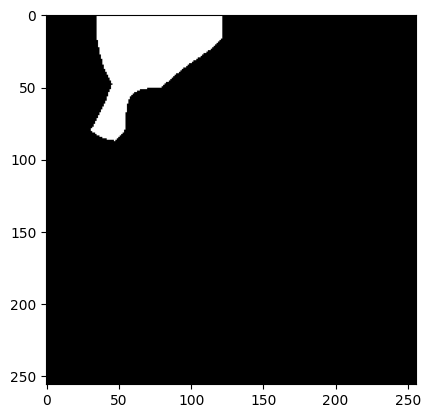

In [293]:
plt.imshow(masks_slow[0][0][1], cmap='gray')

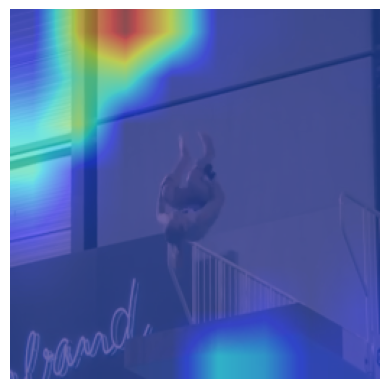

In [292]:
heatmaps = dlf.create_heatmaps(inputs, localisation_maps, cfg.DATA.MEAN, cfg.DATA.STD, colormap='jet')
heatmaps_slow = heatmaps[0]
heatmaps_fast = heatmaps[1]

dlf.frameshow(heatmaps_slow[0], frame_idx=1)